## Classification Notes for Future Meeting (9/04/2024)
Notes for a future meeting - currently playing around with classification !

## Setup

In [148]:
import pathlib 
import pandas as pd 
from xgboost import XGBClassifier
from sklearn import metrics

import sys
sys.path.append(str(pathlib.Path.cwd().parents[0]/ "src" / "classify"))
from prepare_data import load_metrics, create_split
import seaborn as sns
import matplotlib.pyplot as plt

In [149]:
path = pathlib.Path.cwd()

## Helper functions

In [150]:
# define function for getting and plotting feature importance
def show_feature_importances(clf, df):
    # check feature importance
    feature_importances_vals = clf.feature_importances_
    feature_importances = pd.DataFrame({"feature": splits["X_train"].columns, "importance": feature_importances_vals})

    # print sorted by importance
    print(feature_importances.sort_values(by="importance", ascending=False))

    # return plot 
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 15))
    g = sns.barplot(x="importance", y="feature", data=feature_importances.sort_values(by="importance", ascending=False))
    plt.title("Feature importances")
    
    return feature_importances, g

## Stories (Temp 1) Classification

In [151]:
# data 
datapath = path.parents[0] / "metrics"
dataset = "stories"
df = final_df = load_metrics(
                            human_dir=datapath / "human_metrics", 
                            ai_dir=datapath / "ai_metrics",
                            dataset=dataset, temp=1, 
                            human_completions_only=True
                            )


# print how many human and ai samples are in the dataset per temperature
print(df.groupby(["is_human"]).size())

[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
is_human
0    20000
1     5000
dtype: int64


In [152]:
clf = XGBClassifier(enable_categorical=True, use_label_encoder=False, random_state=129)

# drop doc length and pos_prop_space (some NAs in humans apparently) # see glossary for all pos tags https://github.com/explosion/spaCy/blob/master/spacy/glossary.py cols_to_drop = ["doc_length", "pos_prop_SPACE"]
cols_to_drop = ["pos_prop_SPACE"]

new_df = df.drop(cols_to_drop, axis=1)

# all features
splits = create_split(new_df, random_state=129, val_test_size=0.15, outcome_col="is_human", verbose=False)

clf.fit(splits["X_train"], splits["y_train"])

# eval
y_pred = clf.predict(splits["X_val"])
print(metrics.classification_report(splits["y_val"], y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       0.99      0.98      0.98       750

    accuracy                           0.99      3750
   macro avg       0.99      0.99      0.99      3750
weighted avg       0.99      0.99      0.99      3750



                             feature  importance
56            sentence_length_median    0.387539
27                         oov_ratio    0.091475
52          proportion_unique_tokens    0.043461
19                       gunning_fog    0.035728
5            dependency_distance_std    0.033210
..                               ...         ...
62            symbol_to_word_ratio_#    0.000000
14  duplicate_paragraph_chr_fraction    0.000000
3               contains_lorem ipsum    0.000000
30                        perplexity    0.000000
51               proportion_ellipsis    0.000000

[69 rows x 2 columns]


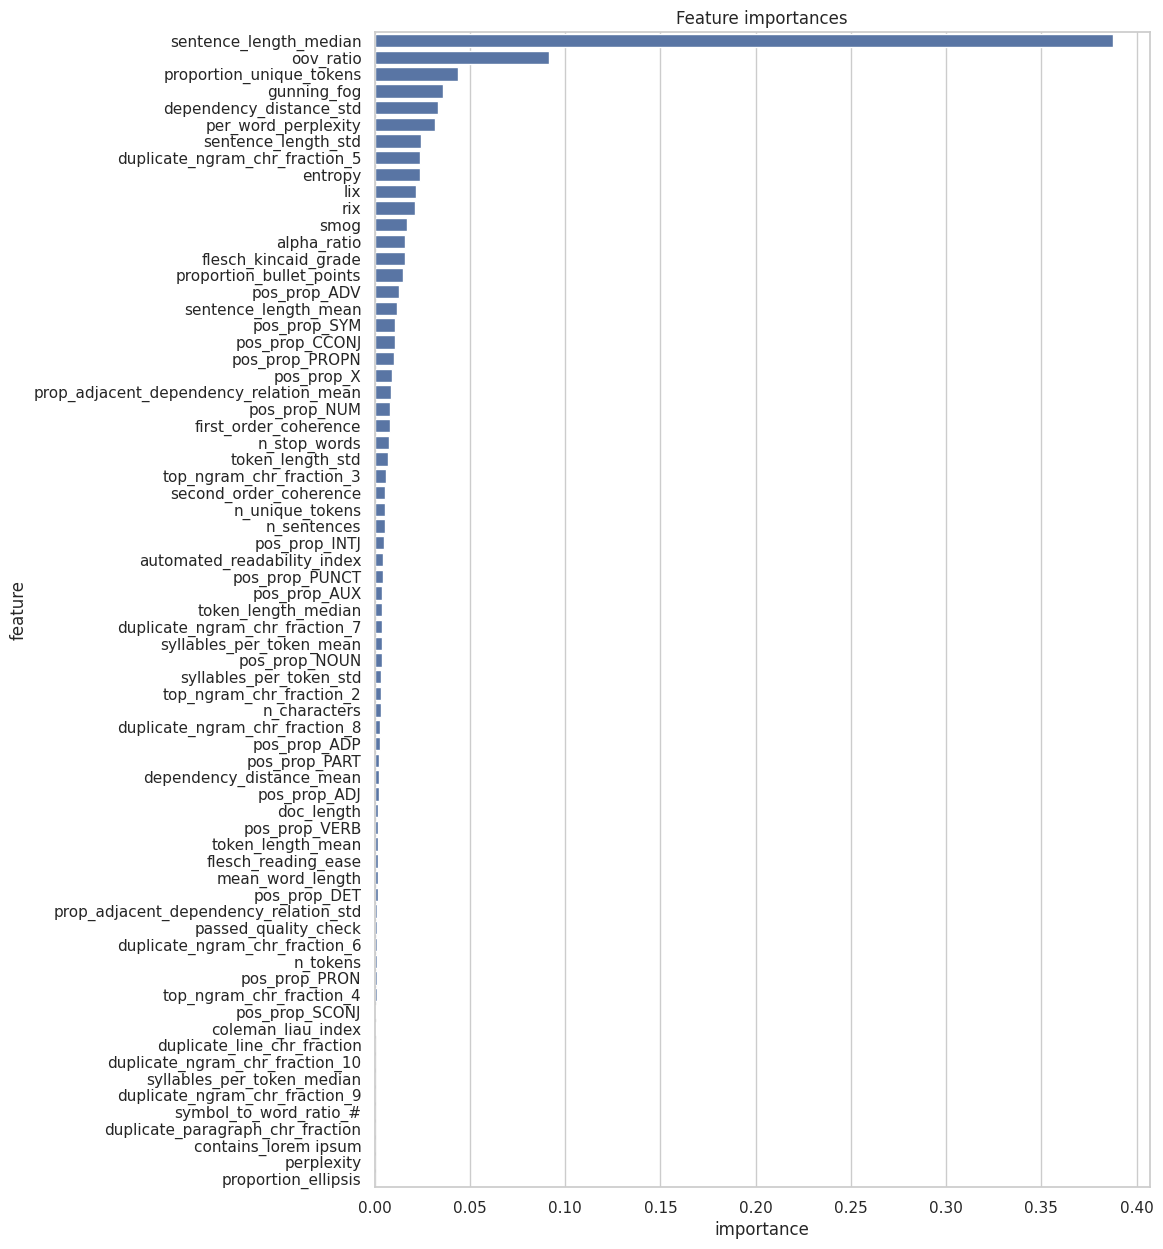

In [153]:
feature_importances, plot = show_feature_importances(clf, splits["X_train"])

In [154]:
features = ["proportion_unique_tokens", "alpha_ratio", "lix", "entropy", "per_word_perplexity"]
splits = create_split(df, random_state=129,
                        val_test_size=0.15, 
                        outcome_col="is_human", 
                        verbose=False, feature_cols=features
                        )

clf.fit(splits["X_train"], splits["y_train"])

# eval
y_pred = clf.predict(splits["X_val"])
print(metrics.classification_report(splits["y_val"], y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3000
           1       0.89      0.82      0.85       750

    accuracy                           0.94      3750
   macro avg       0.92      0.90      0.91      3750
weighted avg       0.94      0.94      0.94      3750



                    feature  importance
2                       lix    0.430217
0  proportion_unique_tokens    0.297669
1               alpha_ratio    0.126583
3                   entropy    0.092919
4       per_word_perplexity    0.052612


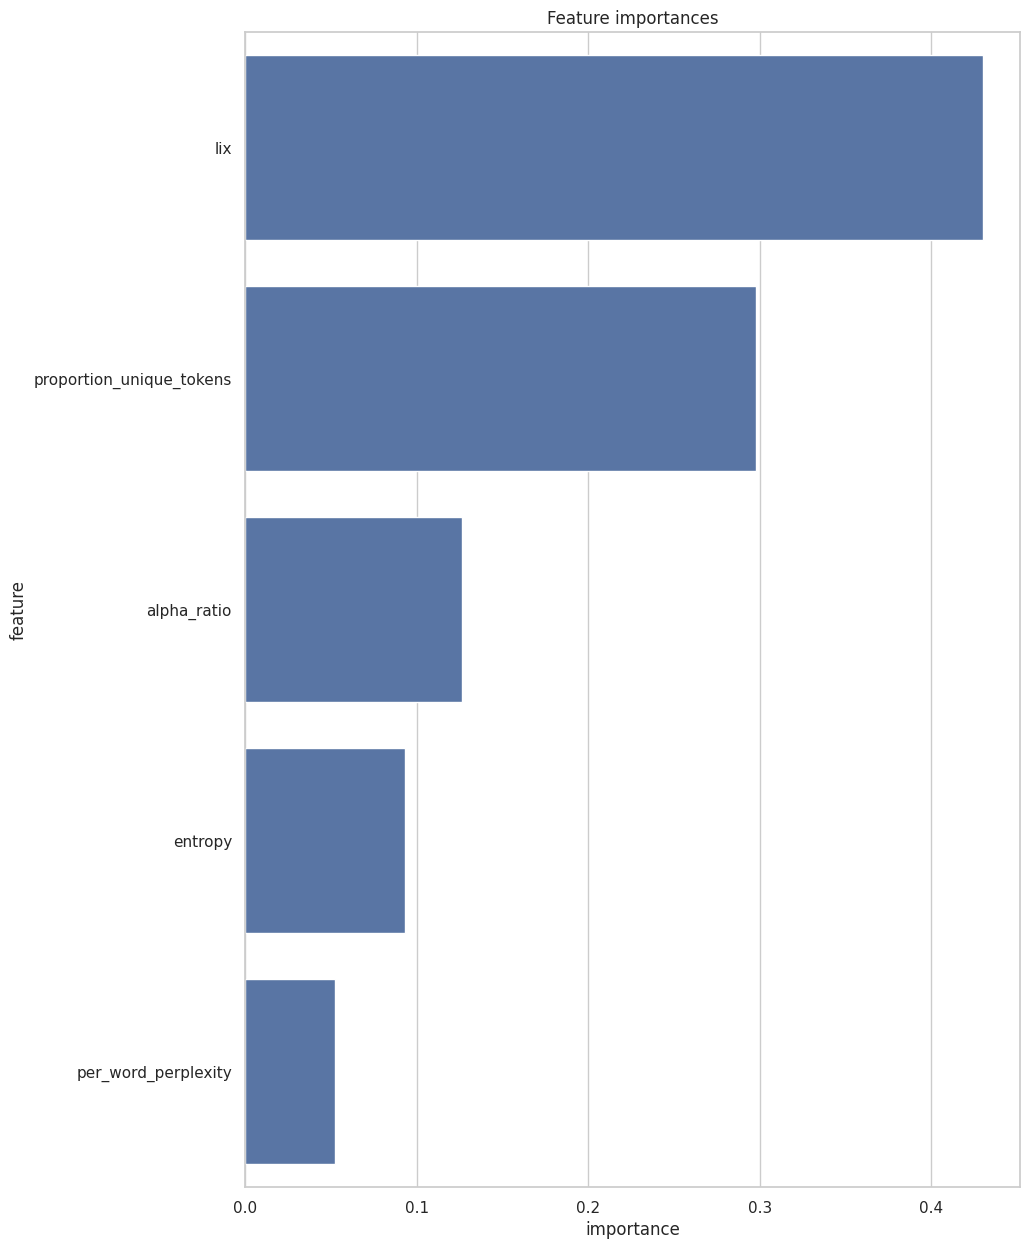

In [155]:
feature_importances, plot = show_feature_importances(clf, splits["X_train"])

## Imbalanced Dataset? 

In [156]:
# define funtion to check imbalance from splits dict 
def check_imbalance(ai_dir, human_dir, temp=1):
    # create dict for saving imbalances
    imbalance = {}

    for dataset in ["stories", "mrpc", "dailydialog", "dailymail_cnn"]:
        df = load_metrics(human_dir=human_dir, ai_dir=ai_dir, dataset=dataset, temp=temp)
        splits = create_split(df, random_state=129, val_test_size=0.15, outcome_col="is_human", verbose=False)
        
        # dict with counts for each split
        imbalance[dataset] = {'train': splits['y_train'].value_counts(),
                              'val': splits['y_val'].value_counts(),
                              'test': splits['y_test'].value_counts()}
        
    # convert to df 
    imbalance_df = pd.DataFrame.from_dict({(dataset, split): imbalance[dataset][split] for dataset in imbalance.keys() for split in imbalance[dataset].keys()}, orient='index')
    imbalance_df.index.names = ['Dataset', 'Split']
    imbalance_df.reset_index(inplace=True)

    return imbalance_df

In [157]:
imbalance_df = check_imbalance(human_dir=datapath / "human_metrics", 
                            ai_dir=datapath / "ai_metrics")
print(imbalance_df) # where 0 is ai and 1 is human

[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
          Dataset  Split      0     1
0         stories  train  14000  3500
1         stories    val   3000   750
2         stories   test   3000   750
3            mrpc  train  10920  2730
4            mrpc    val   2340   585
5            mrpc   test   2340   585
6     dailydialog  train  14000  3500
7   

## Correlation Matrix

In [158]:
# filter irrelevant cols out
cols_to_drop = ["id", "unique_id", "sample_params", "temperature", "prompt_number", "contains_lorem ipsum"]
filtered_df = df.drop(cols_to_drop, axis=1)

In [159]:
corrM = filtered_df.corr()

/tmp/ipykernel_34863/3352751554.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrM = filtered_df.corr()


<Axes: >

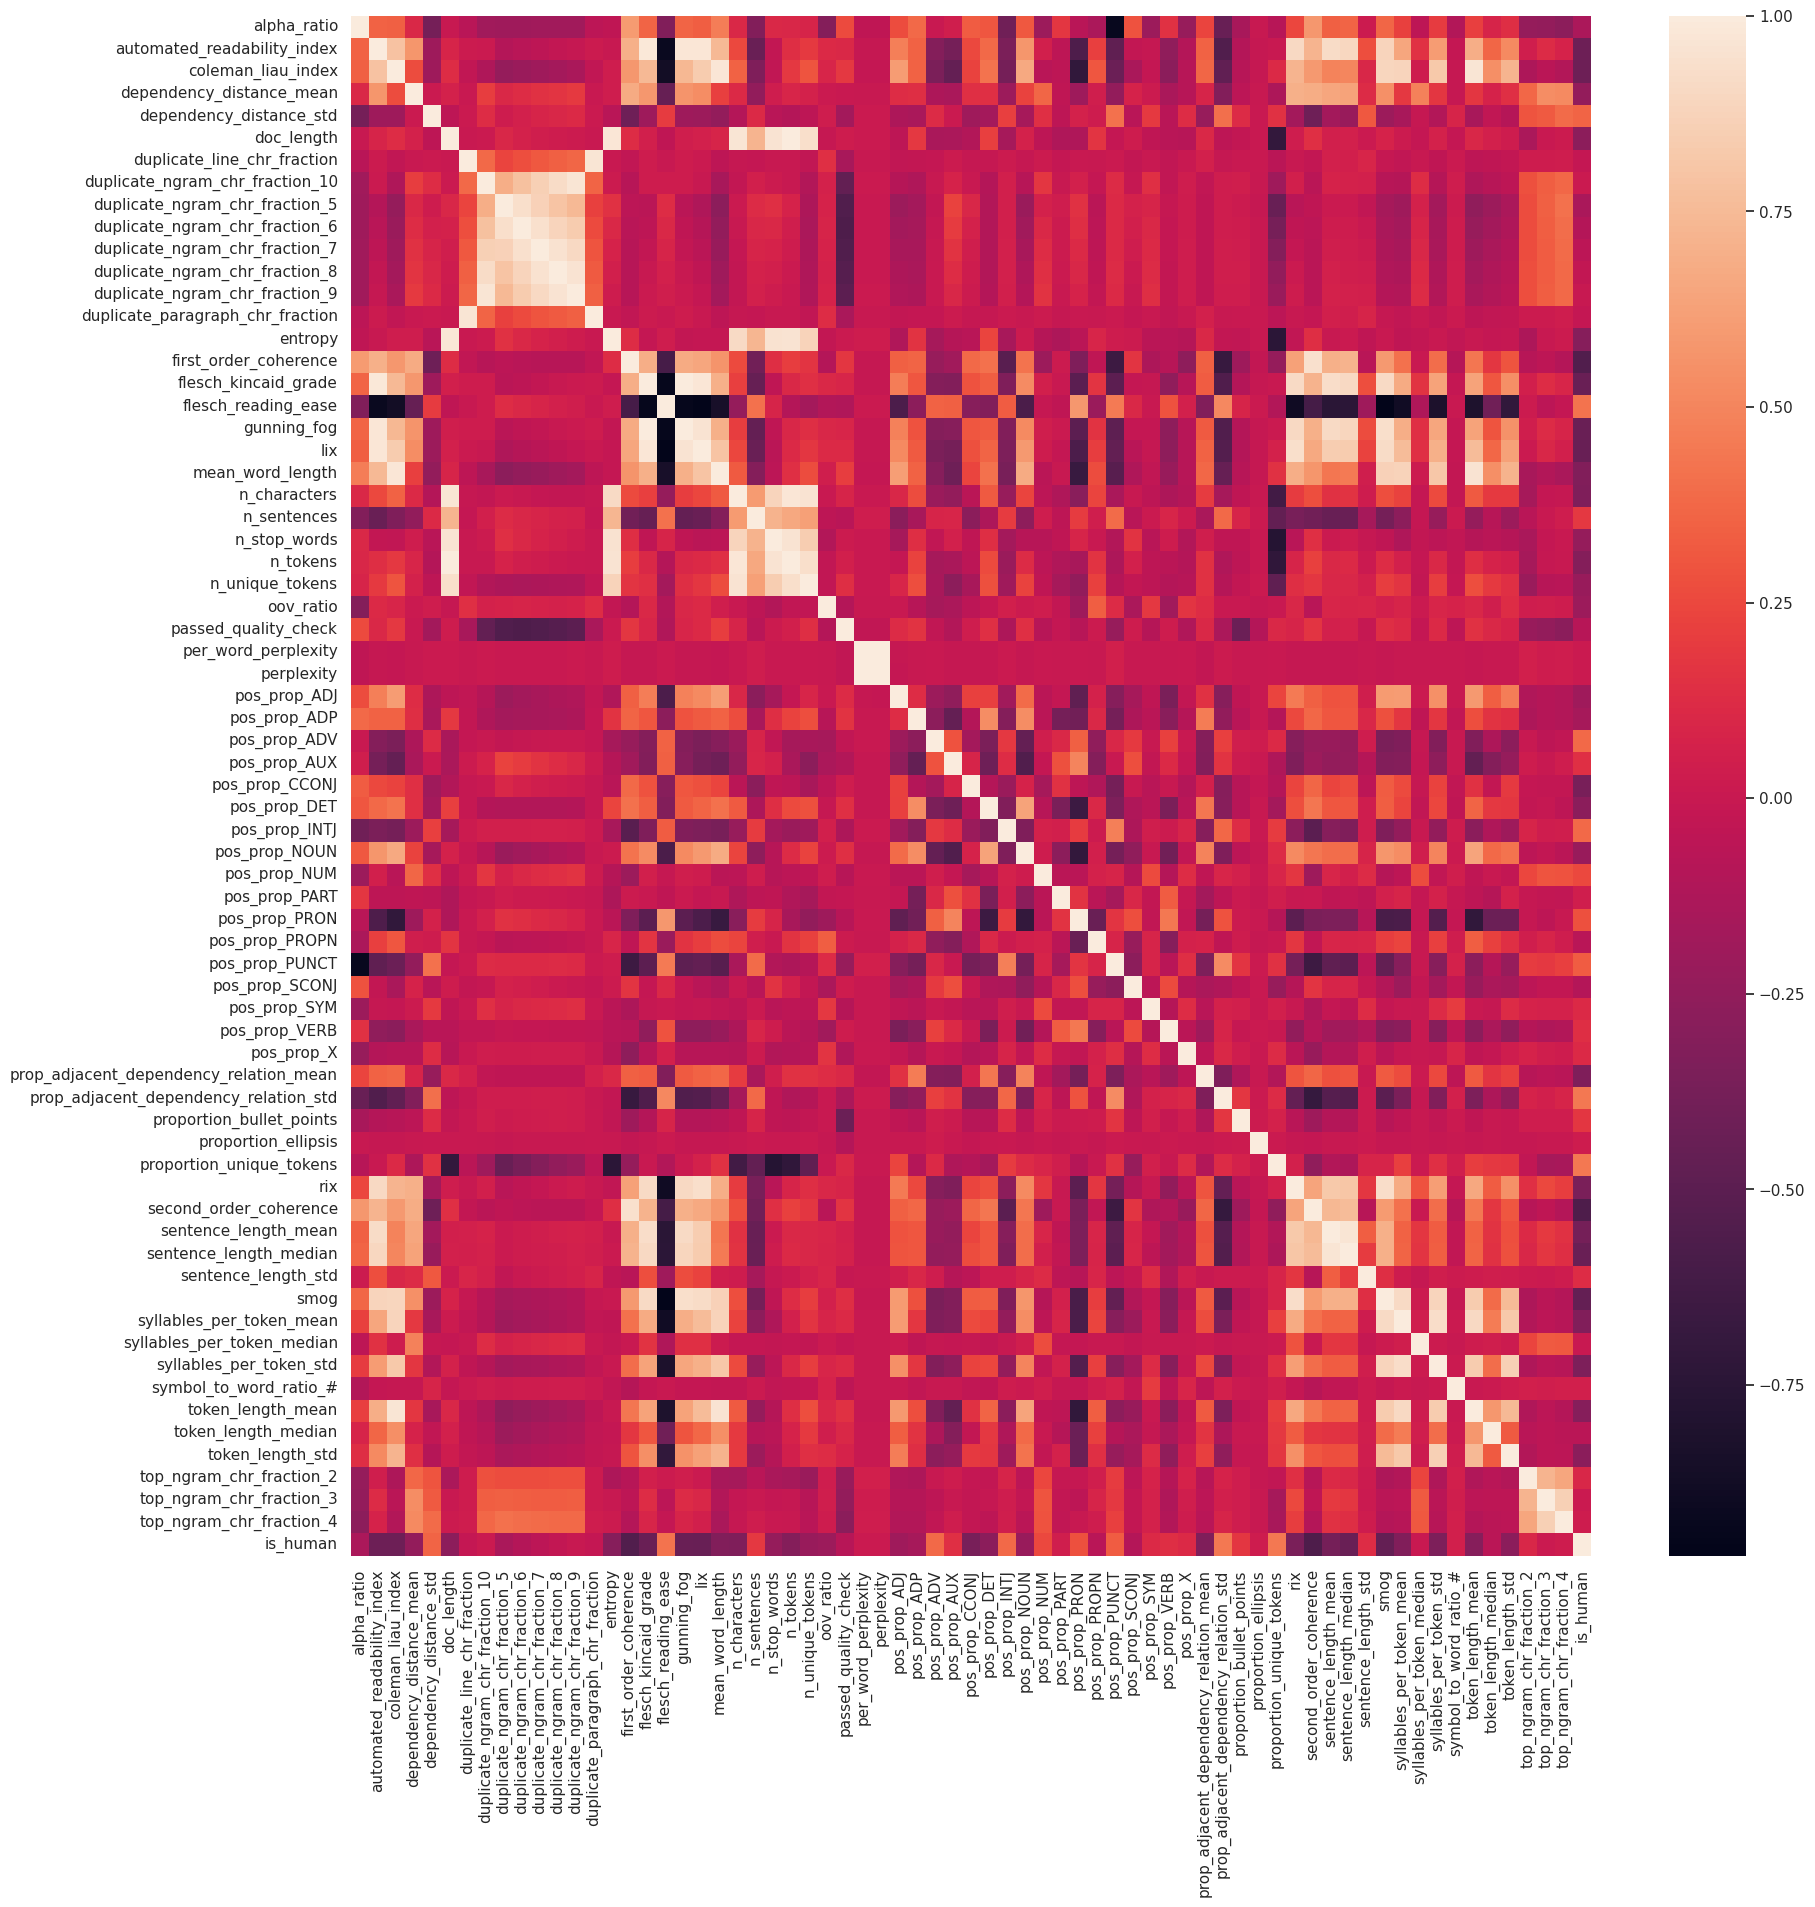

In [160]:
# drop nan
sns.set_theme(rc={'figure.figsize':(20, 20)})

# drop pos_prop_space as it is NA for is_human, then drop all other cols that is na (temporarily)
corrM = corrM.drop("pos_prop_SPACE", axis=1)

sns.heatmap(corrM.dropna())

In [161]:
test_df = df[["pos_prop_SPACE", "is_human", "model"]]
test_df

# check proportion of is_human that has pos_prop_SPACE as NA
test_df[test_df["pos_prop_SPACE"].isna()]["is_human"].value_counts()

1    5000
0       1
Name: is_human, dtype: int64